In [35]:
import os
import numpy as np
import datetime
import cv2 
import tensorflow as tf
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Activation,Conv2D,Dense,MaxPool2D,Dropout,Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure, imshow, axis
from matplotlib.image import imread
from IPython.display import Image, display

##### Defining the images path and shape

In [2]:
Training_path = './Training'
test_path = './Test'
input_shape = (254,254,3)
batch = 64

#### Displaying few images from each class


 FIRE


<Figure size 432x288 with 0 Axes>

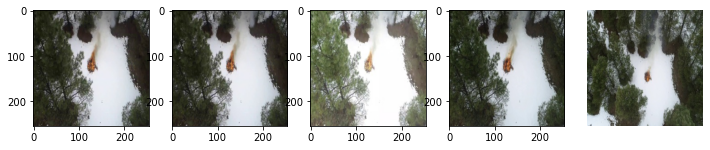

There are  25018  images in  Fire class

 NO_FIRE


<Figure size 432x288 with 0 Axes>

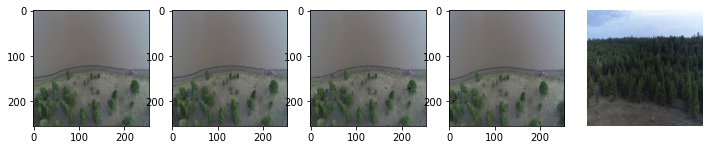

There are  14357  images in  No_Fire class


In [33]:
num = []
for label in labels:
    path = './{0}/{1}/'.format(Training_path,label)
    folder_data = os.listdir(path)
    k = 0
    fig = figure()
    f,ax = plt.subplots(1,5,figsize=(12, 6))
    print('\n', label.upper())
    for image_path in folder_data:
        if k < 5:           
            image = imread(path+image_path)           
            ax[k].imshow(image)                        
        k = k+1
    num.append(k)
    plt.show()
    print('There are ', k,' images in ', label, 'class')

#### Checking the distribution of each Class (Number of images in Fire and No-fire)

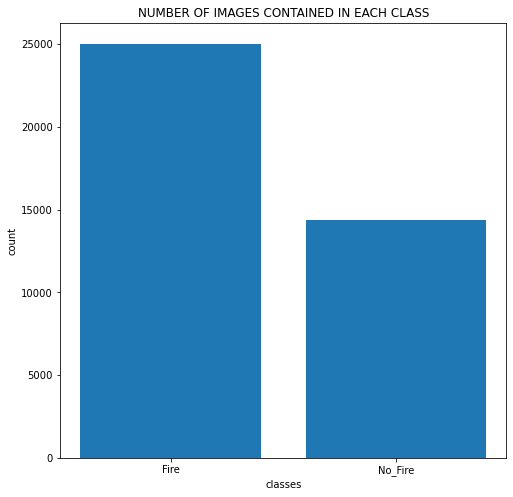

In [5]:
plt.figure(figsize = (8,8))
plt.bar(labels, num)
plt.title('NUMBER OF IMAGES CONTAINED IN EACH CLASS')
plt.xlabel('classes')
plt.ylabel('count')
plt.show()

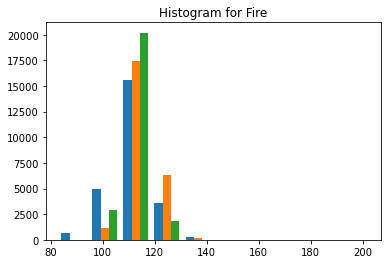

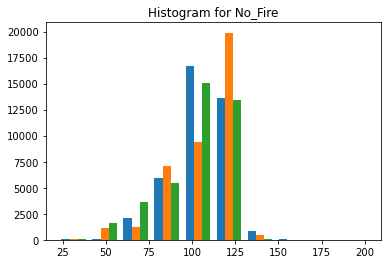

In [40]:
for dirname, _, filenames in os.walk(Training_path):
    for filename in filenames:
        (os.path.join(dirname, filename))
labels = os.listdir(Training_path)
results=[]
for label in labels:
    path = './{0}/{1}/'.format(Training_path,label)
    folder_data = os.listdir(path)
    for image_path in folder_data:                
            img = cv2.imread(path+image_path)
            avg_color_per_row = np.average(img, axis=0)
            avg_color = np.average(avg_color_per_row, axis=0)
            results.append(avg_color) 
    np_results = np.array(results) 
    plt.hist(np_results)
    plt.title("Histogram for {}".format(label))
    plt.show()            

### Image Augmentation

In [6]:
train_images = ImageDataGenerator(rotation_range=40,
                                     width_shift_range=0.1,
                                     height_shift_range=0.1,
                                     horizontal_flip=True,
                                     vertical_flip=True,
                                     rescale=1.0/255,
                                     zoom_range=0.6,
                                     fill_mode='nearest',
                                     validation_split=0.2)

train_generator = train_images.flow_from_directory(Training_path, 
                                                   target_size=(254,254),
                                                   color_mode='rgb',
                                                   class_mode='binary',
                                                   batch_size=batch,
                                                   shuffle=True,
                                                   subset='training')

validation_generator = train_images.flow_from_directory(Training_path, 
                                                        target_size=(254,254),
                                                        color_mode='rgb',
                                                        class_mode='binary',
                                                        batch_size=batch,
                                                        shuffle=True,
                                                        subset='validation')

Found 31501 images belonging to 2 classes.
Found 7874 images belonging to 2 classes.


In [8]:
test_images = ImageDataGenerator(rescale=1.0/255)

test_generator = test_images.flow_from_directory(test_path, 
                                                    target_size=(254,254), 
                                                    color_mode='rgb', 
                                                    class_mode='binary',
                                                    shuffle=False,
                                                    batch_size=batch)


Found 8617 images belonging to 2 classes.


### CNN Baseline Model

In [46]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 252, 252, 32)      896       
_________________________________________________________________
activation_24 (Activation)   (None, 252, 252, 32)      0         
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 126, 126, 32)      0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 124, 124, 32)      9248      
_________________________________________________________________
activation_25 (Activation)   (None, 124, 124, 32)      0         
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 60, 60, 64)       

#### Plot the model flow diagram

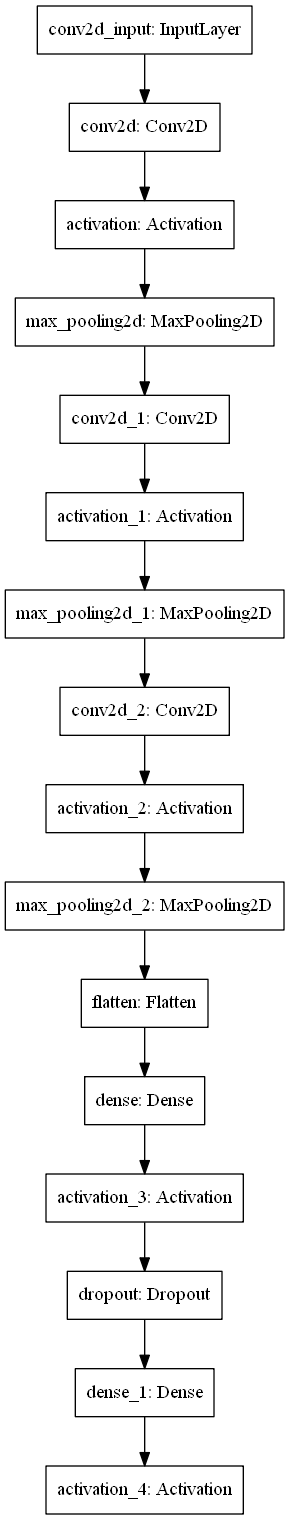

In [15]:
plot_model(model)

In [13]:
%%time
es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=10, verbose=1)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)
mcp = ModelCheckpoint(filepath='weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

tb = TensorBoard('logs')

history = model.fit(train_generator,
                    steps_per_epoch=train_generator.samples  // batch,
                    epochs=10,
                    validation_data = validation_generator, 
                    validation_steps = validation_generator.samples // batch,
                    callbacks=[es, rlr, mcp, tb],
                    verbose=1
    )
model.save('./ver2.h5')

Epoch 1/10
  1/492 [..............................] - ETA: 0s - loss: 0.6951 - accuracy: 0.4688WARNING:tensorflow:From C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
492/492 [==============================] - ETA: 0s - loss: 0.3908 - accuracy: 0.8572 
Epoch 00001: val_loss improved from inf to 0.05285, saving model to weights.h5
492/492 [==============================] - 5812s 12s/step - loss: 0.3908 - accuracy: 0.8572 - val_loss: 0.0528 - val_accuracy: 0.9977
Epoch 2/10
492/492 [==============================] - ETA: 0s - loss: 0.2140 - accuracy: 0.9232
Epoch 00002: val_loss did not improve from 0.05285
492/492 [==============================] - 4491s 9s/step - loss: 0.2140 - accuracy: 0.9232 - val_loss: 0.2311 - val_accuracy: 0.8462
Epoch 3/10
492/492 [========================

### Plot Accuracy & Loss plot for training and validation

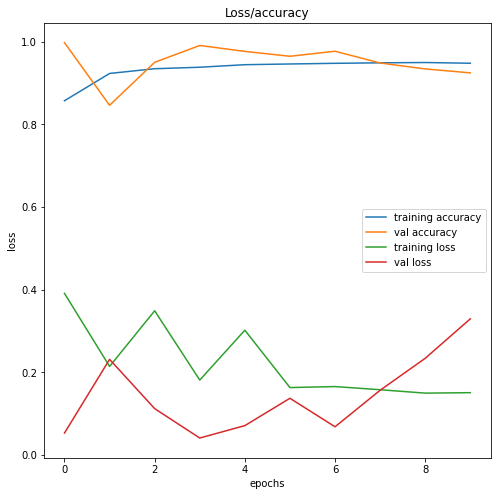

In [14]:
plt.figure(figsize = (8,8))
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss/accuracy')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

### Load the saved model

In [43]:
saved_model = load_model('./ver2.h5')
saved_model.evaluate(test_generator)

135/135 [==============================] - 178s 1s/step - loss: 2.5582 - accuracy: 0.6510


[2.5581953525543213, 0.651038646697998]